In [5]:
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import re

In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
from wordcloud import WordCloud
import os

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, silhouette_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency, multinomial
from scipy.sparse import hstack, csr_matrix

import nltk
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize, RegexpTokenizer, regexp_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, LancasterStemmer, PorterStemmer
from nltk.probability import FreqDist
from nltk import WordNetLemmatizer, pos_tag
from nltk.util import bigrams
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
#nltk.download('all')
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.metrics import BigramAssocMeasures

import itertools
import string
import contractions

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from copy import deepcopy

from xgboost import XGBClassifier

from joblib import parallel_backend

from memory_profiler import profile

from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
data = pd.read_csv('../data/Combined Data.csv')

In [16]:
# Updating perc_upper to calculate based on number of words
def perc_upper_words(text): 
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b[a-zA-Z\'-]+\b', text) # Including apostrophes and hyphens
    words = [word for word in words if not re.search(r'\d', word)] # Filter out numbers
    if not words:
        return 0
    uppercase_words = [word for word in words if word.isupper()]
    return len(uppercase_words) / len(words) * 100

data['perc_upper_words'] = data['statement'].apply(perc_upper_words)

upper_sorted = data.sort_values(by='perc_upper_words', ascending=False)
upper_sorted.head()

,Unnamed: 0,statement,status,perc_upper_words
964,964,THANK GOD,Normal,100.0
3865,3865,ANYONE BUY ME LIGHT STICK HIS DREAMCACTHER PLS...,Normal,100.0
5912,5912,QWUEERRRRREEEEEEEERE QUEEUWUUEUQUEUUQU QUE!?#?...,Normal,100.0
3985,3985,WHAT TO SAY TO DREAMIES????,Normal,100.0
5917,5917,#PECAT WHOSE NAME IS SI ALI MOCHTAR NYEBELIN #,Normal,100.0


In [17]:
upper_stats = data.groupby('status')['perc_upper_words'].agg(['mean', 'min', 'max'])
upper_stats

,mean,min,max
status,,,
Anxiety,5.448665,0.0,100.000000
Bipolar,5.793845,0.0,25.000000
Depression,5.695736,0.0,100.000000
Normal,3.874615,0.0,100.000000
Personality disorder,4.926243,0.0,27.118644
Stress,5.455538,0.0,100.000000
Suicidal,7.940715,0.0,100.000000


In [18]:
# Define function to remove emojis
def remove_emojis(text):
    # Regex pattern to match emojis (covers a wide range of emojis)
    emoji_pattern = re.compile(
        '['
        '\U0001F600-\U0001F64F'  # emoticons
        '\U0001F300-\U0001F5FF'  # symbols & pictographs
        '\U0001F680-\U0001F6FF'  # transport & map symbols
        '\U0001F700-\U0001F77F'  # alchemical symbols
        '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        '\U0001FA00-\U0001FA6F'  # Chess Symbols
        '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        '\U00002700-\U000027BF'  # Dingbats
        '\U000024C2-\U0001F251' 
        ']+', 
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

# Define function to preprocess text
def clean_text(text):
    if not isinstance(text, str):
        return""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'[^\w\s]', '', text) # Remove special char's & punct
    text = re.sub(r'\[|\]', '', text)  # Remove square brackets
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = remove_emojis(text) # Apply emoji function from above
    return text

data['cleaned_statement'] = data['statement'].apply(lambda x: clean_text(x))

# Creating list of stop words
stopwords_list = stopwords.words('english')

# Excluding 'not'
important_words = ['not']

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define function to tokenize, remove stopwords, and lemmatize
def tokenize_stopwords_lemmatize(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [w for w in tokens if w not in stopwords_list or w in important_words]
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in cleaned_tokens]
    return lemmatized_tokens

# Tokenize
data['tokens'] = data['cleaned_statement'].apply(tokenize_stopwords_lemmatize)

# Remove 'like' from tokens, now that we've made bigrams
def remove_like(tokens):
    return [token for token in tokens if token != 'like']

# Apply function
data['tokens'] = data['tokens'].apply(remove_like)

# Remove 'not' from tokens, now that we've made bigrams
def remove_not(tokens):
    return [token for token in tokens if token != 'not']

# Apply function
data['tokens'] = data['tokens'].apply(remove_not)

columns_to_keep = ['status', 'statement', 'perc_upper_words', 'tokens']
filtered_df = data.loc[:, columns_to_keep]
filtered_df.head()

# Set rows with empty 'tokens' lists to NaN
filtered_df.loc[filtered_df['tokens'].apply(lambda x: len(x) == 0), 'tokens'] = np.nan

# Dropping NaNs
filtered_df = filtered_df.dropna(subset=['tokens'])

# Remove 'like' from tokens, now that we've made bigrams
def remove_feel(tokens):
    return [token for token in tokens if token != 'feel']

def remove_might(tokens):
    return [token for token in tokens if token!= 'might']

# Apply function
data['tokens'] = data['tokens'].apply(remove_feel)
filtered_df['tokens'] = filtered_df['tokens'].apply(remove_feel)

data['tokens'] = data['tokens'].apply(remove_might)
filtered_df['tokens'] = filtered_df['tokens'].apply(remove_might)

# Set rows with empty 'tokens' lists to NaN
filtered_df.loc[filtered_df['tokens'].apply(lambda x: len(x) == 0), 'tokens'] = np.nan

# Dropping NaNs
filtered_df = filtered_df.dropna(subset=['tokens'])

# Convert token lists to strings
filtered_df['joined_tokens'] = filtered_df['tokens'].apply(lambda x: ' '.join(x))

# Drop rows where 'status' is 'Personality disorder'
filtered_df = filtered_df[filtered_df['status'] != 'Personality disorder']

# Relabeling stress as anxiety
filtered_df.loc[filtered_df['status'] == 'Stress', 'status'] = 'Anxiety'

# Relabeling depression rows that should be suicidal
# Step 1: Filter rows where status is 'Depression' and tokens contain 'suicide' or 'suicidal'
filtered_rows = filtered_df[(filtered_df['status'] == 'Depression') & 
                            (filtered_df['tokens'].apply(lambda x: 'suicide' in x or 'suicidal' in x))]

# Step 2: Update status to 'Suicidal' for these filtered rows
filtered_df.loc[filtered_rows.index, 'status'] = 'Suicidal'

filtered_df['status'].value_counts(normalize=True)

# Function to check if the text contains specific bigrams
def has_specific_bigrams(text, bigrams):
    for bigram in bigrams:
        if all(word in text.split() for word in bigram):
            return True
    return False

# Filter rows with status 'Depression'
depression_df = filtered_df[filtered_df['status'] == 'Depression']

# Define the bigrams to search for
target_bigrams = [('kill', 'myself'), ('want', 'die')]

# Find rows containing the specific bigrams
filtered_rows = depression_df[depression_df['joined_tokens'].apply(lambda x: has_specific_bigrams(x, target_bigrams))]

# Assuming filtered_rows is a subset of filtered_df and has the same indices
filtered_df.loc[filtered_rows.index, 'status'] = 'Suicidal'



In [20]:
upper_stats = filtered_df.groupby('status')['perc_upper_words'].agg(['mean', 'min', 'max'])
upper_stats

,mean,min,max
status,,,
Anxiety,5.560865,0.0,100.0
Bipolar,6.002482,0.0,25.0
Depression,5.601627,0.0,100.0
Normal,3.909294,0.0,100.0
Suicidal,7.595251,0.0,100.0


In [26]:
# Function to filter, sort, and print statements
def print_statements_by_status(df, status_value, top_n=20):
    # Filter rows by status
    status_df = df[df['status'] == status_value]
    
    # Sort by 'perc_upper_words' in descending order
    status_df_sorted = status_df.sort_values(by='perc_upper_words', ascending=False)
    
    # Get the top N statements
    top_statements = status_df_sorted.head(top_n)['statement']
    
    # Print statements in the desired format
    print(f"\nTop {top_n} Statements for {status_value}:")
    for idx, statement in enumerate(top_statements):
        print(f"Statement {idx + 1}: {statement}")

# Print statements for 'Bipolar'
print_statements_by_status(filtered_df, 'Bipolar')

# Print statements for 'Depression'
print_statements_by_status(filtered_df, 'Depression')


Top 20 Statements for Bipolar:
Statement 1: WTF?? Walmart.   Of course.
Statement 2: BIPOLAR TOYS R US THEME SONG I wrote this for you. 

*Ahem*

“I don’t wanna come down,
I’m a hypo-manic,
Everything in life right now is freaken terrific!
From sex to thoughts to fantasies,
I have the most energy there is,
GEE WIZ,
I don’t wanna come down,
Cause if I did,
I wouldn’t be a hypo-manic 

*applause* 

Yes. Yes. *bows* Thank you, everyone. 
Statement 3: I don’t think I have bipolar. I don’t think I have it, I think I’m faking everything and I feel frustrated. I think I’ve made it all up in my head. 

I feel fine now that I’m on meds, I think I just need antidepressants not lamictal. I think I’m going to get off lamictal and just ask my therapist if I can get on an anti depressant. 

I think I just have cyclical depression and I’m just a bit cocky and and paranoid and irritable and creative.
Statement 4: Anyone been on venlablue XL? I’m having really bad tremors, I can’t stop shaking.
Statem

In [27]:
# Print statements for 'Depression'
print_statements_by_status(filtered_df, 'Suicidal')


Top 20 Statements for Suicidal:
Statement 1: DANIEL WON!
Statement 2: I KEEP MESSING THINGS UP ALL DAY EVERY DAY THERE IS NOTHING I CAN DO ABOUT PEOPEL WILL HATE ME I WILL SAY TOO MUCH AND THEY WILL HATE ME THEY WILL ALWAYS DO FUCK YOU I FUCKIGN HATE THIS FUCKING LIFE I WISH I WAS FUCKING DEAD WHY THE FUCK CAN I SOCIALIZE WITH PEOPLE
Statement 3: FUCK YOU I FUCKING HATE YOU
Statement 4: GOD! CAN U HERME IM TIRED PLEASE KILL ME I WANT DIE
Statement 5: YOU MAKE ME FUCKING CRY EVERY NIGHT AND YOU DONT EVEN KNOW IT
Statement 6: I WILL PRAY EVERYDAY THAT ALL HUMANS ON THIS PLANET GET CANCER AND DIE A SLOW AND PAINFUL DEATH. I HATE HATE HATE ALL HUMANS ESPECIALLY MY MOTHER, FUCK THAT BITCH SHE CAN GET RAPED!!!! I REALLY WANT TO SHOOT UP A SCHOOL AND TAKE THESE POOR KIDS OFF THIS FUCKING PLANET!!! [SERIOUS] I HATE HUMANS!
Statement 7: IM REALLY ABOUT TO KMS CAUSE THIS DAMN TEST OMG I HATE MYSELF FOR NOT REMEMBERING ITS TODAY
Statement 8: AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [29]:
# Print statements for 'Depression'
print_statements_by_status(filtered_df, 'Anxiety')


Top 20 Statements for Anxiety:
Statement 1: #NAME?
Statement 2: UNDERSTANDING FEEL FEELING«
Statement 3: BY GOD I'M STILL WORRY.
Statement 4: WHY ARE YOU VERY EASY??? WHY HAVE YOU ARRIVED ANXIETY LIKE THIS
Statement 5: FEAR, GIVE UP, WORRY, YES HOW YES???
Statement 6: STOP I'M GAMAU ANXIETY, GUNDAH GULANA AGAIN
Statement 7: ORIGINAL ORIGINAL AT THE END OF THIS END IS ANGRY EVERY HOURS 22.00 FEAR THE MIXTAPE COMES OUT
Statement 8: #NAME?
Statement 9: HEALTHVICES  

HEALTHVICES

IF YOU ARE REALLY CONCERNED ABOUT YOUR HEALTH THEN DON’T EVEN THINK OF IGNORING IT AS IT CAN BE THE MAJOR REASON FOR THE MASSIVE RUSH FOR YOUR HEALTH PROBLEMS OVER IT.

&amp;#x200B;

TAKE THE ADVICE ABOUT YOUR HEALTH FROM THE USA TRUSTED DOCTORS.

&amp;#x200B;

CHECK THE LINK BELOW AND FIND THE ONE WAY BEST SOLUTION ON ALL THE VARIOUS HEALTH PROBLEMS.

&amp;#x200B;

STOP SHAKING YOUR LEGS

BECAUSE ALL THE WAYS ARE NATURAL WAYS. 

AND IT’S BETTER TO TAKE ACTION NOW

INSTEAD OF REGRETING LATER.

&amp;#x200B;

IT I

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Calculate value counts of 'status'
status_counts = data['status'].value_counts().reset_index()
status_counts.columns = ['status', 'count']

# Custom colors
colors = ['#8dd8d3', '#ed8975', '#69c6ef', '#d7e6a3', '#4a4ae7', '#df6fba', '#e4a959']

# Status Distribution Pie Chart
fig = px.pie(status_counts, names='status', values='count', title='Proportion of Each Status Category', 
             color_discrete_sequence=colors)

# Update layout for transparent background and white text
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',
    font_color="white",            # White text
    showlegend=True,               # Show legend
    legend=dict(
    title_font=dict(size=20),  # Title font size
    font=dict(size=16)         # Legend item font size
    )
)


# Update pie chart text and format
fig.update_traces(
    textposition='inside',          # Show percentages inside pie chart
    textinfo='percent',       # Show percentages and labels
    insidetextfont=dict(color='white')   # Set inside text color to white
)

# Save the chart as an image with Kaleido engine
pio.write_image(fig, 'status_distribution.png', engine='kaleido', width=1200, height=800)

# Display the chart
fig.show()

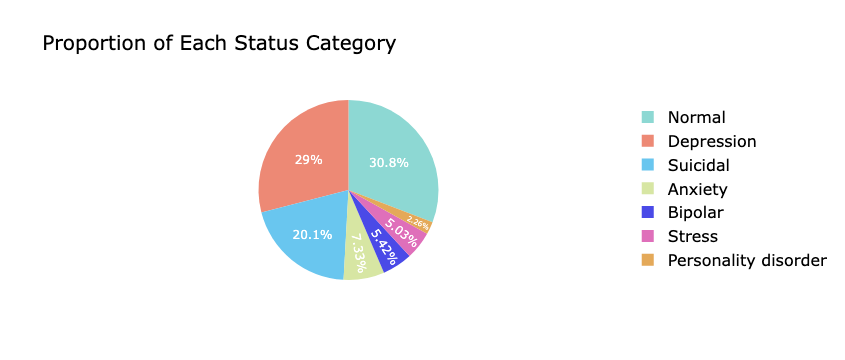

In [4]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Calculate value counts of 'status'
status_counts = data['status'].value_counts().reset_index()
status_counts.columns = ['status', 'count']

# Custom colors
colors = ['#8dd8d3', '#ed8975', '#69c6ef', '#d7e6a3', '#4a4ae7', '#df6fba', '#e4a959']

# Status Distribution Pie Chart
fig = px.pie(status_counts, names='status', values='count', title='Proportion of Each Status Category', 
             color_discrete_sequence=colors)

# Update layout for transparent background and black text
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',
    font_color="black",            # Black text for the entire figure
    title_font=dict(color='black', size=20),  # Black color and size for the title
    showlegend=True,               # Show legend
    legend=dict(
        title_font=dict(size=20, color='black'),  # Black color and size for legend title
        font=dict(size=16, color='black')         # Black color and size for legend items
    )
)

# Update pie chart text and format
fig.update_traces(
    textposition='inside',          # Show percentages inside pie chart
    textinfo='percent',       # Show percentages and labels
    insidetextfont=dict(color='white')   # Set inside text color to white
)

# Save the chart as an image with Kaleido engine
pio.write_image(fig, 'README_status_distribution.png', engine='kaleido', width=1200, height=800)

# Display the chart
fig.show()

In [19]:
# Filter rows where 'status' is 'Anxiety' and get the 'statement' values
anxiety_statements = data.loc[data['status'] == 'Anxiety', 'statement'].head(50)

# Print the first 50 statements
for idx, statement in enumerate(anxiety_statements):
    print(f"Statement {idx + 1}: {statement}")

Statement 1: oh my gosh
Statement 2: trouble sleeping, confused mind, restless heart. All out of tune
Statement 3: All wrong, back off dear, forward doubt. Stay in a restless and restless place
Statement 4: I've shifted my focus to something else but I'm still worried
Statement 5: I'm restless and restless, it's been a month now, boy. What do you mean?
Statement 6: every break, you must be nervous, like something is wrong, but what the heck
Statement 7: I feel scared, anxious, what can I do? And may my family or us be protected :)
Statement 8: Have you ever felt nervous but didn't know why?
Statement 9: I haven't slept well for 2 days, it's like I'm restless. why huh :([].
Statement 10: I'm really worried, I want to cry.
Statement 11: always restless every night, even though I don't know why, what's wrong. strange.
Statement 12: I'm confused, I'm not feeling good lately. Every time I want to sleep, I always feel restless
Statement 13: sometimes what is needed when there is a problem is

In [20]:
# Filter rows where 'status' is 'Anxiety' and get the 'statement' values
anxiety_statements = data.loc[data['status'] == 'Stress', 'statement'].head(50)

# Print the first 50 statements
for idx, statement in enumerate(anxiety_statements):
    print(f"Statement {idx + 1}: {statement}")

Statement 1: He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.
Statement 2: My mom then hit me with the newspaper and it shocked me that she would do this, she knows I don't like play hitting, smacking, striking, hitting or violence of any sort on my person. Do I send out this vibe asking for it from the universe? Then yesterday I decided to take my friend to go help another "friend" move to a new place. While we were driving the friend we are moving strikes me on my should

In [40]:
statement_13_stress = """These past couple of months have been the worst. 
My anxiety has gotten so bad it’s effecting my sleep and relationship. 
I’ve become so paranoid about my health as well. 
I don’t feel like me anymore and I just feel scared all the time now over every little thing. 
I don’t have money to see a therapist either…"""

In [41]:
# Define function to remove emojis
def remove_emojis(text):
    # Regex pattern to match emojis (covers a wide range of emojis)
    emoji_pattern = re.compile(
        '['
        '\U0001F600-\U0001F64F'  # emoticons
        '\U0001F300-\U0001F5FF'  # symbols & pictographs
        '\U0001F680-\U0001F6FF'  # transport & map symbols
        '\U0001F700-\U0001F77F'  # alchemical symbols
        '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        '\U0001FA00-\U0001FA6F'  # Chess Symbols
        '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        '\U00002700-\U000027BF'  # Dingbats
        '\U000024C2-\U0001F251' 
        ']+', 
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

# Define function to preprocess text
def clean_text(text):
    if not isinstance(text, str):
        return""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'[^\w\s]', '', text) # Remove special char's & punct
    text = re.sub(r'\[|\]', '', text)  # Remove square brackets
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = remove_emojis(text) # Apply emoji function from above
    return text

data['cleaned_statement'] = data['statement'].apply(lambda x: clean_text(x))

# Creating list of stop words
stopwords_list = stopwords.words('english')

# Define function to tokenize, remove stopwords, and lemmatize
def tokenize_stopwords(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [w for w in tokens if w not in stopwords_list]
    return cleaned_tokens

# Tokenize
data['tokens'] = data['cleaned_statement'].apply(tokenize_stopwords)

In [42]:
# Import necessary libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download stopwords from NLTK (run this line once)
nltk.download('stopwords')

# Creating list of stop words
stopwords_list = stopwords.words('english')

# Define function to preprocess text
def clean_text(text):
    if not isinstance(text, str):
        return""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'[^\w\s]', '', text) # Remove special char's & punct
    text = re.sub(r'\[|\]', '', text)  # Remove square brackets
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\n', '', text)  # Remove newlines
    return text

statement_13_stress = clean_text(statement_13_stress)

# Define function to tokenize, remove stopwords, and lemmatize
def tokenize_stopwords(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [w for w in tokens if w not in stopwords_list]
    return cleaned_tokens

statement_13_stress = tokenize_stopwords(statement_13_stress)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
statement_13_stress

['past',
 'couple',
 'months',
 'worst',
 'anxiety',
 'gotten',
 'bad',
 'effecting',
 'sleep',
 'relationship',
 'ive',
 'become',
 'paranoid',
 'health',
 'well',
 'dont',
 'feel',
 'like',
 'anymore',
 'feel',
 'scared',
 'time',
 'every',
 'little',
 'thing',
 'dont',
 'money',
 'see',
 'therapist',
 'either']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Define the single statement as a list of words
statement_13_stress = [
    'past', 'couple', 'months', 'worst', 'anxiety', 'gotten', 'bad', 'effecting',
    'sleep', 'relationship', 'ive', 'become', 'paranoid', 'health', 'well', 'dont',
    'feel', 'like', 'anymore', 'feel', 'scared', 'time', 'every', 'little', 'thing',
    'dont', 'money', 'see', 'therapist', 'either'
]

# Join tokens from statement_13_stress into a single string
statement_13_stress_text = ' '.join(statement_13_stress)

# Initialize TF-IDF vectorizer and fit on entire corpus
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['tokens'].apply(lambda x: ' '.join(x)))

# Transform statement_13_stress tokens
tfidf_statement = tfidf_vectorizer.transform([statement_13_stress_text])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Extract TF-IDF values for statement_13_stress tokens
statement_13_stress_tfidf_values = tfidf_statement.toarray()[0]

# Create a DataFrame for statement_13_stress tokens and their TF-IDF values
df_statement_tfidf = pd.DataFrame({
    'Token': feature_names,
    'TF-IDF Value': statement_13_stress_tfidf_values
})

# Custom colors
colors = ['#8dd8d3', '#ed8975', '#69c6ef', '#d7e6a3', '#4a4ae7', '#df6fba', '#e4a959']

# Plot TF-IDF values for statement_13_stress tokens compared to the entire corpus
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
bars = plt.barh(df_statement_tfidf['Token'], df_statement_tfidf['TF-IDF Value'], color=colors)
plt.xlabel('TF-IDF Value', color='white')  # Set xlabel color to white
plt.ylabel('Token', color='white')  # Set ylabel color to white
plt.title('TF-IDF Values for Tokens in statement_13_stress', color='white')  # Set title color to white
plt.gca().invert_yaxis()  # Invert y-axis to display tokens from top to bottom
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['right'].set_visible(False)  # Hide right spine
plt.gca().tick_params(axis='y', labelsize=12, colors='white')  # Adjust tick label size and color for y-axis
plt.gca().set_facecolor('none')  # Set transparent background
plt.tight_layout()

# Save plot with transparent background
plt.savefig('tfidf_plot.png', bbox_inches='tight', transparent=True)
plt.show()

/var/folders/1k/x4fbmx7x5jq2rlv4qntp985r0000gn/T/ipykernel_78115/1482409974.py:48: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



KeyboardInterrupt: 

In [5]:
# Drop rows with NaN values in 'statement' column
data.dropna(subset=['statement'], inplace=True)

# Function to calculate word count
def count_words(text):
    return len(text.split())

# Apply word count function to 'statement' column
data['word_count'] = data['statement'].apply(count_words)

# Group by 'status' and calculate mean, max, min word count
grouped_data = data.groupby('status')['word_count'].agg(['mean', 'max', 'min'])

print("Mean, Max, Min Word Count by Status:")
print(grouped_data)

Mean, Max, Min Word Count by Status:
                            mean   max  min
status                                     
Anxiety               143.837022  1592    1
Bipolar               176.200216  4804    4
Depression            168.021488  4239    1
Normal                 17.246283   255    1
Personality disorder  179.346332  5419    5
Stress                114.585234  1606    1
Suicidal              146.440293  6300    1
